### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import functools

### Part 1: CMA-ES
Implement CMA-ES below.

In [8]:
def cmaes(fn, dim, num_iter=10):
  """Optimizes a given function using CMA-ES.

  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []
  n=100
  L= int(p_keep*population_size)
  for t in range(num_iter):
    # WRITE CODE HERE
    print("iteration: ", t)
    samples=np.random.multivariate_normal(mu, cov, n)
    #pdb.set_trace()
    score_list=[]
    for i in range(population_size):
      #score=0
      #for j in range(L):
      score = fn(samples[i])
      
      #score = score/L
      score_list.append(score)

    #score_list.append(score)

    score= np.array(score_list)
    #pdb.set_trace()
    elite_ind= np.argpartition(score, -L)[-L:]
    best_cols= samples[elite_ind]
    #best_sample_vec = np.max(score_list) #[best_cols[:,k] for k in range(best_cols.shape[1])]
    mu=np.mean(best_cols, axis=0)
    #print(best_cols.shape)
    #print(mu.shape)
    #pdb.set_trace()
    cov = np.mean((best_cols- mu[np.newaxis,:])**2, axis=0) + noise*np.eye(dim)
    #pdb.set_trace()
    mu_vec.append(mu)
    mean_sample_vec.append(np.mean(score_list))
    best_sample_vec.append(np.max(score_list))

  return mu_vec, best_sample_vec, mean_sample_vec

In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution.

In [9]:
def test_fn(x):
  goal = np.array([65, 49])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

/tmp/ipykernel_125217/601711003.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples=np.random.multivariate_normal(mu, cov, n)


Run the following cell to visualize CMA-ES.

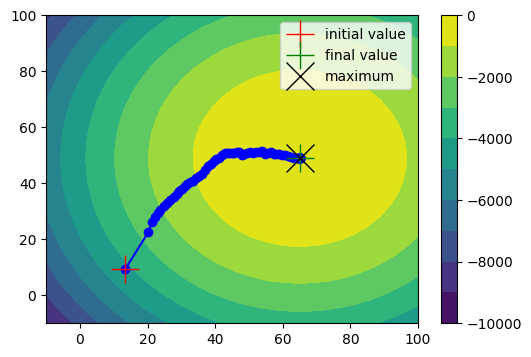

In [10]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o')
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([65], [49], 'kx', ms=20, label='maximum')
plt.legend()
plt.show()

Next, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [61]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env, iters=1):
  assert len(params) == 5 , "params should have length 5"
  ## WRITE CODE HERE
  total_rewards=0
  total_rewards= float(total_rewards)
  #pdb.set_trace()
  for i in range(iters):
    s,_= env.reset()
    done=False
    trunc=False
    total=0
    count=0
    while not done and trunc==False :
      count= count +1
      #pdb.set_trace()
      a= _get_action(s, params)
      
      s, r, done, trunc , _= env.step(a)
      total += float(r)

      if count==200:
        break
    
    #print("total reward: ", total)
    total_rewards += total/iters
  
  total_rewards = total_rewards
  return total_rewards

The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [62]:
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)
#print("done with env")
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)

/home/kaust/anaconda3/envs/drl/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/kaust/anaconda3/envs/drl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_125217/601711003.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples=np.random.multivariate_normal(mu, cov, n)


iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9


len best sample vec:  10


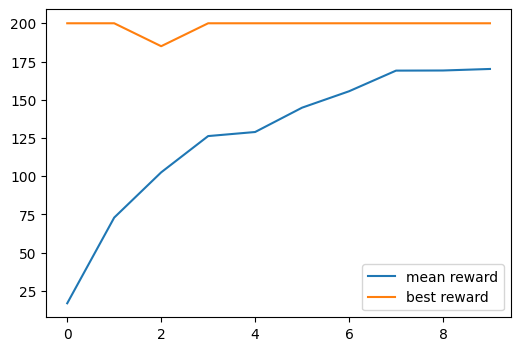

In [64]:
plt.figure(figsize=(6, 4))
print("len best sample vec: ", len(mean_sample_vec))
x = np.arange(len(mean_sample_vec))
plt.plot(x, mean_sample_vec, label='mean reward')   
plt.plot(x, best_sample_vec, label='best reward')
plt.legend()    

plt.show()

In [65]:
env = gym.make('CartPole-v0')
params= np.array([-1,-1,-1,-1,-1])
params2= np.array([1,0,1,0,1])
params3= np.array([0,1,2,3,4])
rew=rl_fn(params, env, 1000)
print(rew)
rew2=rl_fn(params2, env, 1000)
print("rew2: ", rew2)
rew3=rl_fn(params3, env, 1000)
print("rew3: ", rew3)

15.651999999999937
rew2:  14.390999999999943
rew3:  9.395999999999983
